In [1]:
import numpy as np
import json

########## Récupération des valeurs dans les fichiers ##########
datafile = "normal1000.json"
f = open(datafile, "r")
data_train = [json.loads(line) for line in f.readlines()]

datafile = "abnormal100.json"
f = open(datafile, "r")
data_test = [json.loads(line) for line in f.readlines()]

f.close()

In [52]:
from sklearn.preprocessing import MinMaxScaler
a = np.array([1.,2,3])
b = np.array([0,4.,1.7])
c = np.array([7,5.,9.1])

print(a)
print(b)
print(c)

print(np.stack((a, b,c), axis=-1))
data = np.stack((a, b,c), axis=-1)

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)

print(scaled)
print(scaler.inverse_transform(scaled))
#print(scaler.fit(a))
#print(scaler.data_max_)

[[1.  2.  3. ]
 [0.  4.  1.7]]
[0.  4.  1.7]
[7.  5.  9.1]
[1.  2.  3.  0.  4.  1.7]


ValueError: all input arrays must have the same shape

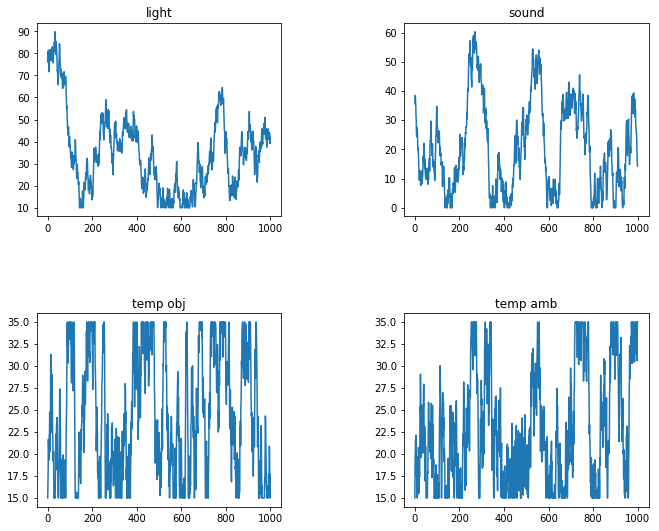

In [37]:
from sklearn.preprocessing import MinMaxScaler
########## Préprocessing des données  ##########

# Lecture des données pour l'apprentissage et création d'une liste pour chaque capteur
list_light, list_sound, list_temp_object, list_temp_ambient = [], [], [], []
for d in data_train:
    list_light.append(d["light"])
    list_sound.append(d["sound"])
    list_temp_object.append(d["temp"]["object"])
    list_temp_ambient.append(d["temp"]["ambient"])

nb_time_stamps = len(data_train)

# Conversion des listes en tableaux numpy
light_train = np.array(list_light)
sound_train = np.array(list_sound)
temp_object_train = np.array(list_temp_object)
temp_ambient_train = np.array(list_temp_ambient)

# Création d'un tableau avec toutes les valeurs
train_values = np.stack((light_train,sound_train,temp_object_train,temp_ambient_train), axis=-1)
#print(train_values)

# plot training values
pyplot.figure(1,figsize=(10, 8))

pyplot.subplot(221)
pyplot.plot(light_train)
pyplot.title("light")

pyplot.subplot(222)
pyplot.plot(sound_train)
pyplot.title("sound")

pyplot.subplot(223)
pyplot.plot(temp_object_train)
pyplot.title("temp obj")

pyplot.subplot(224)
pyplot.plot(temp_ambient_train)
pyplot.title("temp amb")

pyplot.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.5)
pyplot.show()

In [ ]:
# Normalisation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(train_values)
print(scaled)

In [5]:
from pandas import DataFrame
from pandas import concat

# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.head())
print(reframed.shape)
print(reframed.values)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)   var2(t)   var3(t)  \
1   0.827725   0.590695   0.000000   0.000000  0.881698  0.603541  0.087931   
2   0.881698   0.603541   0.087931   0.234234  0.876097  0.638360  0.153553   
3   0.876097   0.638360   0.153553   0.248216  0.894379  0.597759  0.332892   
4   0.894379   0.597759   0.332892   0.330047  0.871167  0.579162  0.291751   
5   0.871167   0.579162   0.291751   0.303490  0.831040  0.518522  0.213913   

    var4(t)  
1  0.234234  
2  0.248216  
3  0.330047  
4  0.303490  
5  0.356700  
(999, 8)
[[0.82772537 0.59069522 0.         ... 0.60354122 0.08793131 0.23423437]
 [0.8816984  0.60354122 0.08793131 ... 0.6383604  0.1535531  0.24821588]
 [0.87609695 0.6383604  0.1535531  ... 0.59775913 0.33289204 0.33004739]
 ...
 [0.42237776 0.36681147 0.2528603  ... 0.28765792 0.03893164 0.7816981 ]
 [0.41753538 0.28765792 0.03893164 ... 0.27840357 0.         0.93121453]
 [0.3646916  0.27840357 0.         ... 0.23645989 0.13030546 1

In [18]:
# split into train and test sets
values = reframed.values
n_train_values = 800
train = values[:n_train_values, :]
test = values[n_train_values:, :]
print(train.shape)
print(test.shape)
# split into input and outputs
train_X, train_y = train[:, :-4], train[:, 4:]
test_X, test_y = test[:, :-4], test[:, 4:]
print(test_X)
print(test_y)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(800, 8)
(199, 8)
[[0.43226241 0.         0.61021269 0.        ]
 [0.39663723 0.         0.67615705 0.04833179]
 [0.36194682 0.05402225 0.53206373 0.        ]
 [0.39582291 0.01361913 0.6964329  0.03305624]
 [0.36199728 0.07216484 0.69472299 0.19530638]
 [0.31432997 0.07517916 0.77404822 0.11359671]
 [0.28246334 0.1376562  0.72164122 0.        ]
 [0.25326591 0.19576025 0.77438217 0.        ]
 [0.21655748 0.11900625 0.64179904 0.21680459]
 [0.19626331 0.12089802 0.69516786 0.01536369]
 [0.21944225 0.0520077  0.72819208 0.10465695]
 [0.22350511 0.03398467 0.83775074 0.14320483]
 [0.1773957  0.         0.89887634 0.07384743]
 [0.12127764 0.         0.98784135 0.        ]
 [0.12452663 0.         1.         0.04593194]
 [0.0930512  0.04104256 0.79068626 0.        ]
 [0.07397686 0.03212059 0.63535241 0.        ]
 [0.04029256 0.         0.40554547 0.        ]
 [0.05920662 0.07550635 0.54604807 0.        ]
 [0.04499814 0.14007074 0.39390623 0.        ]
 [0.05784309 0.16616499 0.6142984  0.     

Train on 800 samples, validate on 199 samples
Epoch 1/50
 - 3s - loss: 0.3693 - val_loss: 0.3352
Epoch 2/50
 - 0s - loss: 0.3138 - val_loss: 0.2910
Epoch 3/50
 - 0s - loss: 0.2724 - val_loss: 0.2575
Epoch 4/50
 - 0s - loss: 0.2414 - val_loss: 0.2323
Epoch 5/50
 - 0s - loss: 0.2217 - val_loss: 0.2152
Epoch 6/50
 - 0s - loss: 0.2097 - val_loss: 0.2035
Epoch 7/50
 - 0s - loss: 0.2015 - val_loss: 0.1953
Epoch 8/50
 - 0s - loss: 0.1947 - val_loss: 0.1878
Epoch 9/50
 - 0s - loss: 0.1880 - val_loss: 0.1802
Epoch 10/50
 - 0s - loss: 0.1810 - val_loss: 0.1726
Epoch 11/50
 - 0s - loss: 0.1736 - val_loss: 0.1652
Epoch 12/50
 - 0s - loss: 0.1659 - val_loss: 0.1572
Epoch 13/50
 - 0s - loss: 0.1578 - val_loss: 0.1487
Epoch 14/50
 - 0s - loss: 0.1495 - val_loss: 0.1404
Epoch 15/50
 - 0s - loss: 0.1413 - val_loss: 0.1326
Epoch 16/50
 - 0s - loss: 0.1331 - val_loss: 0.1253
Epoch 17/50
 - 0s - loss: 0.1253 - val_loss: 0.1186
Epoch 18/50
 - 0s - loss: 0.1180 - val_loss: 0.1122
Epoch 19/50
 - 0s - loss: 0

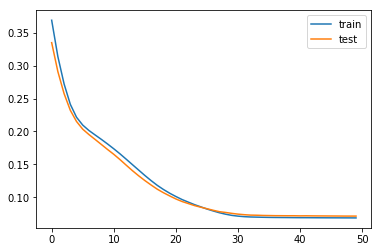

In [9]:
import tensorflow as tf
from matplotlib import pyplot

# design network
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.Dense(4))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=30, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [10]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

(199, 4)
(199, 4)
Test RMSE light: 3.049
Test RMSE sound: 3.041
Test RMSE temp obj: 2.460
Test RMSE temp amb: 2.659


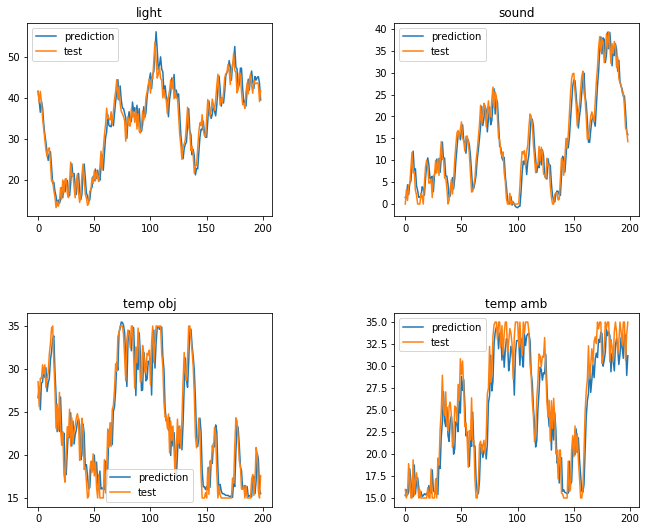

In [29]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# invert scaling for forecast
#inv_yhat = np.concatenate((yhat, test_X[:, 4:]), axis=1)
inv_yhat = scaler.inverse_transform(yhat)
inv_yhat_light = inv_yhat[:,0]
inv_yhat_sound = inv_yhat[:,1]
inv_yhat_to = inv_yhat[:,2]
inv_yhat_ta = inv_yhat[:,3]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 4))
#inv_y = np.concatenate((test_y, test_X[:, 4:]), axis=1)
inv_y = scaler.inverse_transform(test_y)
inv_y_light = inv_y[:,0]
inv_y_sound = inv_y[:,1]
inv_y_to = inv_y[:,2]
inv_y_ta = inv_y[:,3]
#print(inv_y_light)
#print(inv_y_sound)
#print(inv_y_to)
#print(inv_y_ta)

print(inv_y.shape)
print(inv_yhat.shape)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_light, inv_yhat_light))
print('Test RMSE light: %.3f' % rmse)
rmse = sqrt(mean_squared_error(inv_y_sound, inv_yhat_sound))
print('Test RMSE sound: %.3f' % rmse)
rmse = sqrt(mean_squared_error(inv_y_to, inv_yhat_to))
print('Test RMSE temp obj: %.3f' % rmse)
rmse = sqrt(mean_squared_error(inv_y_ta, inv_yhat_ta))
print('Test RMSE temp amb: %.3f' % rmse)

# plot predictions
pyplot.figure(1,figsize=(10, 8))

pyplot.subplot(221)
pyplot.plot(inv_yhat_light, label='prediction')
pyplot.plot(inv_y_light, label='test')
pyplot.legend()
pyplot.title("light")

pyplot.subplot(222)
pyplot.plot(inv_yhat_sound, label='prediction')
pyplot.plot(inv_y_sound, label='test')
pyplot.legend()
pyplot.title("sound")

pyplot.subplot(223)
pyplot.plot(inv_yhat_to, label='prediction')
pyplot.plot(inv_y_to, label='test')
pyplot.legend()
pyplot.title("temp obj")

pyplot.subplot(224)
pyplot.plot(inv_yhat_ta, label='prediction')
pyplot.plot(inv_y_ta, label='test')
pyplot.legend()
pyplot.title("temp amb")

pyplot.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.5)
pyplot.show()

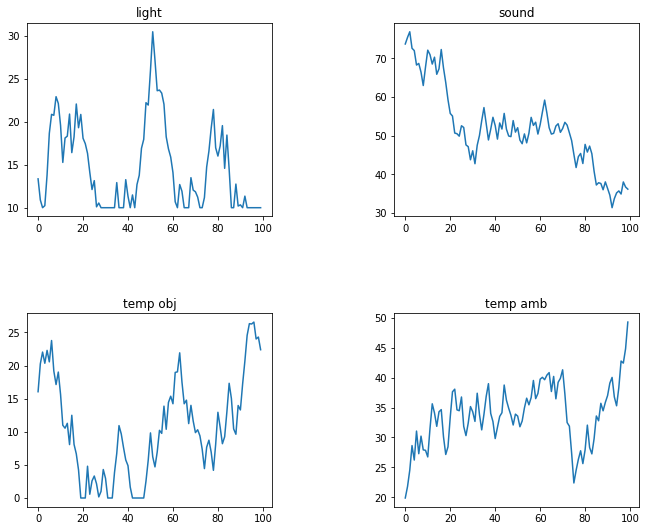

In [39]:
########## Préprocessing des données anormales  ##########

# Lecture des données pour l'apprentissage et création d'une liste pour chaque capteur
list_light, list_sound, list_temp_object, list_temp_ambient = [], [], [], []
for d in data_test:
    list_light.append(d["light"])
    list_sound.append(d["sound"])
    list_temp_object.append(d["temp"]["object"])
    list_temp_ambient.append(d["temp"]["ambient"])

# Conversion des listes en tableaux numpy
light_test = np.array(list_light)
sound_test = np.array(list_sound)
temp_object_test = np.array(list_temp_object)
temp_ambient_test = np.array(list_temp_ambient)

# Création d'un tableau avec toutes les valeurs
test_values = np.stack((light_test,sound_test,temp_object_test,temp_ambient_test), axis=-1)
#print(test_values)

# plot training values
pyplot.figure(1,figsize=(10, 8))

pyplot.subplot(221)
pyplot.plot(light_test)
pyplot.title("light")

pyplot.subplot(222)
pyplot.plot(sound_test)
pyplot.title("sound")

pyplot.subplot(223)
pyplot.plot(temp_object_test)
pyplot.title("temp obj")

pyplot.subplot(224)
pyplot.plot(temp_ambient_test)
pyplot.title("temp amb")

pyplot.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.5)
pyplot.show()

In [40]:
# Normalisation
scaler = MinMaxScaler(feature_range=(0, 1))
test_scaled = scaler.fit_transform(test_values)
print(test_scaled.shape)

(100, 4)


In [41]:
# frame as supervised learning --> pas nécessaire, besoin seulement d'un shift
reframed_test = series_to_supervised(test_scaled, 1, 1)
print(reframed_test.head())
print(reframed_test.shape)
print(reframed_test.values)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)   var2(t)   var3(t)  \
1   0.163934   0.930451   0.604095   0.000000  0.044054  0.967848  0.762535   
2   0.044054   0.967848   0.762535   0.065055  0.000000  1.000000  0.829398   
3   0.000000   1.000000   0.829398   0.158349  0.011615  0.906062  0.765826   
4   0.011615   0.906062   0.765826   0.297988  0.185865  0.893041  0.839005   
5   0.185865   0.893041   0.839005   0.215805  0.422562  0.810763  0.773811   

    var4(t)  
1  0.065055  
2  0.158349  
3  0.297988  
4  0.215805  
5  0.380404  
(99, 8)
[[0.1639338  0.93045069 0.60409548 0.         0.04405366 0.96784807
  0.76253494 0.06505518]
 [0.04405366 0.96784807 0.76253494 0.06505518 0.         1.
  0.82939826 0.1583492 ]
 [0.         1.         0.82939826 0.1583492  0.01161532 0.90606187
  0.7658262  0.29798789]
 [0.01161532 0.90606187 0.7658262  0.29798789 0.18586525 0.89304145
  0.83900532 0.2158052 ]
 [0.18586525 0.89304145 0.83900532 0.2158052  0.42256188 0.8107633
  

In [53]:
real_values = reframed_test.values
# split into input and outputs
X, y = real_values[:, :-4], real_values[:, 4:]
# split input in 10 arrays
nb_seq = 10
X = np.array_split(X,nb_seq)
print(X[0].shape)
# reshape input to be 3D [samples, timesteps, features]
for i in range(nb_seq):
    X[i] = X[i].reshape((X[i].shape[0], 1, X[i].shape[1]))

(10, 4)


In [59]:
# make a prediction
ypred = []
for i in range(nb_seq):
    ypred.append(model.predict(X[i]))
ypred = np.array(ypred)
ypred = np.concatenate((ypred))
print(ypred.shape)

(99, 4)


In [60]:
inv_ypred = scaler.inverse_transform(ypred)
inv_ypred_light = inv_ypred[:,0]
inv_ypred_sound = inv_ypred[:,1]
inv_ypred_to = inv_ypred[:,2]
inv_ypred_ta = inv_ypred[:,3]

y_light = inv_ypred[:,0]
y_sound = inv_ypred[:,1]
y_to = inv_ypred[:,2]
y_ta = inv_ypred[:,3]

In [61]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_ypred_light, y_light))
print('Test RMSE light: %.3f' % rmse)
rmse = sqrt(mean_squared_error(inv_ypred_sound, y_sound))
print('Test RMSE sound: %.3f' % rmse)
rmse = sqrt(mean_squared_error(inv_ypred_to, y_to))
print('Test RMSE temp obj: %.3f' % rmse)
rmse = sqrt(mean_squared_error(inv_ypred_ta, y_ta))
print('Test RMSE temp amb: %.3f' % rmse)

Test RMSE light: 0.000
Test RMSE sound: 0.000
Test RMSE temp obj: 0.000
Test RMSE temp amb: 0.000


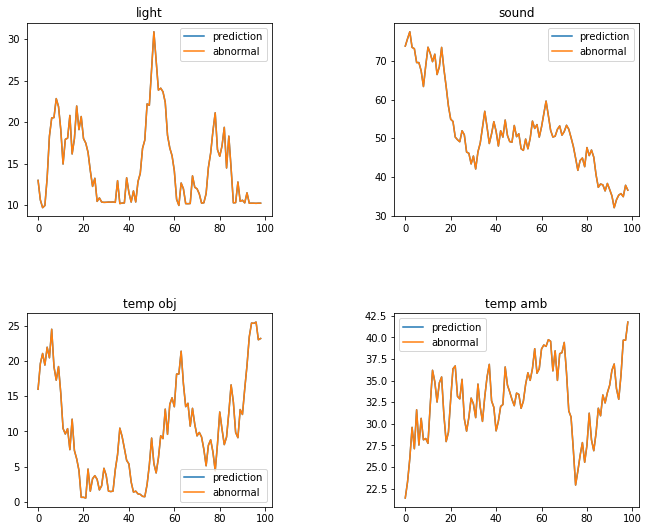

In [62]:
# plot predictions
pyplot.figure(1,figsize=(10, 8))

pyplot.subplot(221)
pyplot.plot(inv_ypred_light, label='prediction')
pyplot.plot(y_light, label='abnormal')
pyplot.legend()
pyplot.title("light")

pyplot.subplot(222)
pyplot.plot(inv_ypred_sound, label='prediction')
pyplot.plot(y_sound, label='abnormal')
pyplot.legend()
pyplot.title("sound")

pyplot.subplot(223)
pyplot.plot(inv_ypred_to, label='prediction')
pyplot.plot(y_to, label='abnormal')
pyplot.legend()
pyplot.title("temp obj")

pyplot.subplot(224)
pyplot.plot(inv_ypred_ta, label='prediction')
pyplot.plot(y_ta, label='abnormal')
pyplot.legend()
pyplot.title("temp amb")

pyplot.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.5)
pyplot.show()